# Mapping Representations

Recall that we can think of a deep model learning as series of new "representations" at each layer of its processing, each representation making the overall solution that the network is trying to achieve easier. We can understand what the information the representations at each layer captures by mapping the representations in a 2-dimensional scatter plot that we can inspect.

Let's start by loading MNIST and a trained model:

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from matplotlib import offsetbox
from keras.datasets import mnist
from keras.models import model_from_json
from keras.utils import np_utils
from keras import backend as K
from sklearn.manifold import TSNE

(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

Using TensorFlow backend.


First we will load the MNIST model we trained beforehand.

In [2]:
# Load model structure
model = model_from_json(open('mnist_cnn.json').read())

# Load model weights
model.load_weights('mnist_cnn_weights.h5')

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

## Mapping data with tSNE

[tSNE](https://lvdmaaten.github.io/tsne/) is a commonly used visualization tool in deep learning. It is a dimensionality reduction technique: it takes high-dimensional data and maps them into a 2-dimensional space such that the relationships of the data is preserved. We call this low-dimensional mapping an "embedding".

Below is a function that creates a plot of an embedding. We will soon see what it looks like and how to interpret it.

In [16]:
# Adapted from http://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html

def plot_embedding(imgs, X, y, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    # Plot colors numbers
    plt.figure(figsize=(10,10))
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        # plot colored number
        plt.text(X[i, 0], X[i, 1], str(y[i]),
                 color=plt.cm.Set1(y[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})

    # Add image overlays
#     if hasattr(offsetbox, 'AnnotationBbox'):
#         # only print thumbnails with matplotlib > 1.0
#         shown_images = np.array([[1., 1.]])  # just something big
#         for i in range(X.shape[0]):
#             dist = np.sum((X[i] - shown_images) ** 2, 1)
#             if np.min(dist) < 4e-3:
#                 # don't show points that are too close
#                 continue
#             shown_images = np.r_[shown_images, [X[i]]]
#             imagebox = offsetbox.AnnotationBbox(
#                 offsetbox.OffsetImage(imgs[i], cmap=plt.cm.gray_r), X[i])
#             ax.add_artist(imagebox)
    #plt.xticks([]), plt.yticks([])
    plt.xlim([-0.5,1.5])
    plt.ylim([-0.5,1.5])

    if title is not None:
        plt.title(title)

tSNE takes a list of representations for each example data as input and outputs a 2-d location for that example. Below, we do this to the input data itself and plot the result. Read and run the steps below.

In [4]:
# Select the data to embed - in this case the first 1000 training examples
# We reshape the data from its 28x28 size to a flat vector
num_emb = 1000
reps = X_train[:num_emb].reshape([num_emb, 28*28])
print reps.shape

(1000, 784)


In [5]:
# Fit our tSNE mapping to the `reps` data vectors
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=3000, method='exact')
emb = tsne.fit_transform(reps)

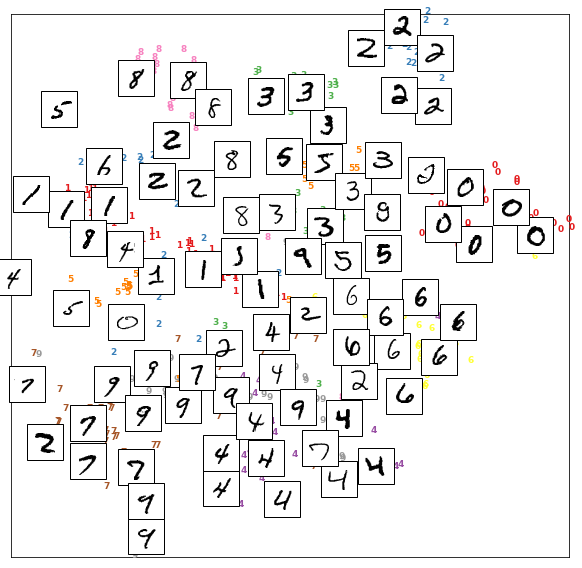

In [6]:
# To make the plot, we input the image data itself, the embedding data we fit with tSNE,
# and class labels for the the data points
num_plot = 500
plot_embedding(np.squeeze(X_train[:num_plot]), emb[:num_plot], y_train[:num_plot])

- - -
### Exercise 1 - interpreting a tSNE plot

Inspect the plot of the raw input data. What do you observe?

tSNE tries to preserve the distances of the data: if points are close to each other in the representation, tSNE tries to keep them close to each other in the embedding.

How do you think this plot might look different if the numbers in our dataset were not centered in the image? Why?
- - -

## Visualizing deep representations

We will now do the same as we did above, but instead of using the raw input data as our representation, we will use the hidden layer activations of your model as the representation.

Here are the layers we can choose to visualize:

In [7]:
model.layers

Here is the function we can use to extract layer outputs. Right now it extracts activations from the first layer. More information on this feature of Keras can be found [here](http://keras.io/getting-started/faq/#how-can-i-visualize-the-output-of-an-intermediate-layer).

In [8]:
get_layer = K.function([model.layers[0].input, K.learning_phase()], [model.layers[1].output])
reps = get_layer([X_train[:num_emb], 0])[0]
print reps.shape

(1000, 14, 14, 10)


- - -
### Exercise 2 - map a deep layer

Below, change the layer function to extract the output for a fully-connected layer deep in your network. Create a tSNE embedding with this layer and plot it.

What do you observe?
1. Characterize the difference between this plot and the last plot.
2. Can you find any "mistakes" in this plot?
3. You might notice clusters of data. Do the relationship between these clusters in the plot seem sensible to you? Can you explain this?
- - -

(1000, 10)


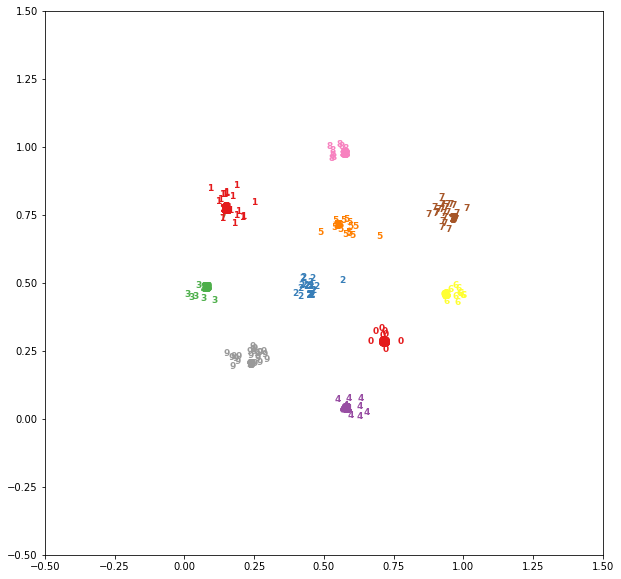

In [18]:
get_layer = K.function([model.layers[0].input, K.learning_phase()], [model.layers[-1].output])
reps = get_layer([X_train[:num_emb], 0])[0]
print reps.shape

# Create a tSNE plot with a deep fully-connected layer
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=3000, method='exact')
emb = tsne.fit_transform(reps)

# To make the plot, we input the image data itself, the embedding data we fit with tSNE,
# and class labels for the the data points
num_plot = 500
plot_embedding(np.squeeze(X_train[:num_plot]), emb[:num_plot], y_train[:num_plot])

reps.shape (1000, 10)
y.shape (1000, 10)
ae.layers [<keras.layers.core.Dense object at 0x1218f60d0>, <keras.layers.core.Dense object at 0x11e00f950>]
emb.shape (1000, 2)


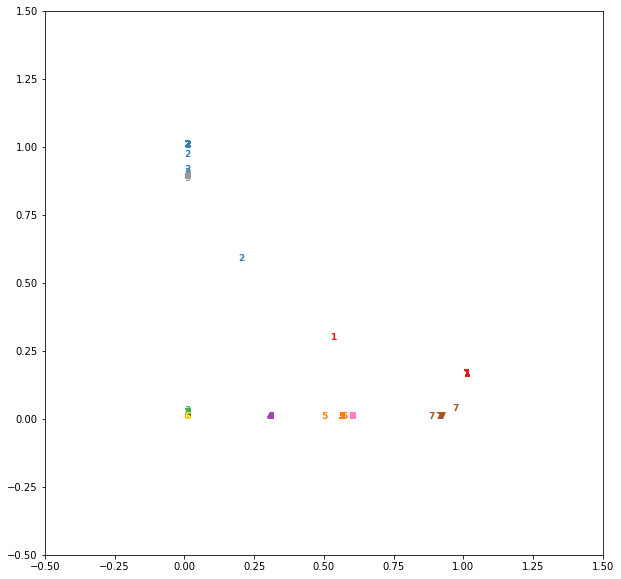

In [19]:
# Try with an auto encoder
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.utils import np_utils

get_layer = K.function([model.layers[0].input, K.learning_phase()], [model.layers[-1].output])
reps = get_layer([X_train[:num_emb], 0])[0] # Hidden layer output
print 'reps.shape', reps.shape

X = reps
y = reps #np_utils.to_categorical(y_train[:num_emb])
print 'y.shape', y.shape

ae = Sequential()
ae.add(Dense(2, input_dim=reps.shape[1], activation='relu'))
ae.add(Dense(y.shape[1], activation='softmax'))
ae.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
ae.fit(X, y, nb_epoch=10, batch_size=32, verbose=0)
print 'ae.layers', ae.layers

from keras import backend as K
get_hidden_layer_output = K.function([ae.layers[0].input],
                                     [ae.layers[0].output])
emb = get_hidden_layer_output([X])[0]
print 'emb.shape', emb.shape

# To make the plot, we input the image data itself, the embedding data,
# and class labels for the the data points
plot_embedding(np.squeeze(X_train), emb, y_train)

- - -
### Bonus Exercise 3 - map a middle layer

Choose another layer in your model and map it as above. You can choose another "flat layer" if your model has one, or you can choose a convolutional layer (in fact, it is interesting to try both). If you choose a convolutional layer, remember you will need to reshape the representations so that they are flat before doing tSNE.

Compared to earlier plots, is there a noticeable difference? Can you explain the relationship among all of the plots we have made?
- - -

In [ ]:
# Map another hidden layer lower in the network